# UIDAI Aadhaar Enrolment Data Analysis

This notebook presents a structured analytical study conducted as part of the UIDAI Data Hackathon.  
The objective is to analyze Aadhaar enrolment data to identify **temporal trends, spatial disparities, age-group imbalances, and anomalous enrolment behavior**, and to translate these findings into actionable operational and policy insights.



## Introduction

**Aadhaar Coverage Sentinel** is a data-driven analytical framework designed to enhance visibility into Aadhaar enrolment patterns across India. While aggregate enrolment figures suggest broad national coverage, they often conceal underlying temporal fluctuations, geographic disparities, and demographic imbalances that affect equitable access to Aadhaar services.

This project leverages official Aadhaar enrolment data to continuously monitor enrolment activity across states and districts. By analyzing temporal trends, spatial concentration, age-group composition, and anomalous enrolment behavior, Aadhaar Coverage Sentinel functions as an early-warning and decision-support system for enrolment governance.

The framework focuses on identifying underperforming regions, detecting irregular enrolment patterns, and highlighting demographic gaps—particularly in early-age enrolment. These insights enable targeted operational planning, efficient resource allocation, and informed policy interventions, moving beyond one-size-fits-all approaches toward more responsive and inclusive Aadhaar enrolment strategies.


## Problem Statement

Despite **nationwide Aadhaar enrolment efforts**, enrolment activity across India is **unevenly distributed** over **time**, **geography**, and **demographic groups**. **Aggregate enrolment figures** often mask **district-level disparities**, **demographic imbalances**, and **recurring operational irregularities** that can affect **service accessibility** and **coverage equity**.

The objective of this study is to **analyze Aadhaar enrolment data** to identify **temporal trends**, **spatial concentration**, **demographic enrolment patterns**, and **persistent underperformance across districts**. By detecting **enrolment volatility**, **anomalous behaviour**, and **regions with consistently low enrolment activity**, the analysis aims to provide **actionable insights** to support **targeted operational planning**, **resource allocation**, and **policy interventions** for improving **Aadhaar enrolment effectiveness** and **inclusivity**.



In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")


## 1.Data Acquisition and Integration

The analysis uses the official Aadhaar enrolment datasets provided by UIDAI.  
The data is supplied as multiple CSV files capturing daily enrolment activity across states, districts, and pincodes, along with age-group-wise enrolment counts.

All CSV files belonging to the enrolment dataset are loaded and consolidated into a single dataframe to enable consistent analysis across time and geography.


In [28]:
import zipfile
import os

zip_path = "/content/api_data_aadhar_enrolment.zip"
extract_path = "/content/enrolment_data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

dfs = []

for root, dirs, files in os.walk(extract_path):
    for file in files:
        if file.endswith(".csv"):
            file_path = os.path.join(root, file)
            dfs.append(pd.read_csv(file_path))

print(f"Number of CSV files loaded: {len(dfs)}")

enrolment_df = pd.concat(dfs, ignore_index=True)


Number of CSV files loaded: 3


### Dataset Consolidation

The Aadhaar enrolment dataset is provided as three separate CSV files within a single compressed archive.  
Each file represents a partial extract of enrolment records with an identical schema.

All three CSV files are programmatically loaded and concatenated into a single unified dataset prior to analysis.  
This ensures complete coverage of the enrolment data and prevents analytical bias arising from partial file-level analysis.


In [29]:
[len(pd.read_csv(os.path.join(root, f)))
 for root, _, files in os.walk("/content/enrolment_data")
 for f in files if f.endswith(".csv")]


[6029, 500000, 500000]

## 2.Data Inspection and Validation

Initial inspection is performed to understand the dataset structure, data types, and value ranges.  
This step helps identify inconsistencies, missing values, or anomalies that must be addressed before analysis.


In [30]:
enrolment_df.head()


,date,state,district,pincode,age_0_5,age_5_17,age_18_greater
0,31-12-2025,Karnataka,Bidar,585330,2,3,0
1,31-12-2025,Karnataka,Bidar,585402,6,0,0
2,31-12-2025,Karnataka,Bidar,585413,1,0,0
3,31-12-2025,Karnataka,Bidar,585418,1,2,0
4,31-12-2025,Karnataka,Bidar,585421,4,3,0


In [31]:
enrolment_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006029 entries, 0 to 1006028
Data columns (total 7 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   date            1006029 non-null  object
 1   state           1006029 non-null  object
 2   district        1006029 non-null  object
 3   pincode         1006029 non-null  int64 
 4   age_0_5         1006029 non-null  int64 
 5   age_5_17        1006029 non-null  int64 
 6   age_18_greater  1006029 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 53.7+ MB


In [32]:
enrolment_df.describe()


,pincode,age_0_5,age_5_17,age_18_greater
count,1.006029e+06,1.006029e+06,1.006029e+06,1.006029e+06
mean,5.186415e+05,3.525709e+00,1.710074e+00,1.673441e-01
std,2.056360e+05,1.753851e+01,1.436963e+01,3.220525e+00
min,1.000000e+05,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.636410e+05,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.174170e+05,2.000000e+00,0.000000e+00,0.000000e+00
75%,7.001040e+05,3.000000e+00,1.000000e+00,0.000000e+00
max,8.554560e+05,2.688000e+03,1.812000e+03,8.550000e+02


## 3.Data Cleaning and Preprocessing

To ensure analytical accuracy, the dataset undergoes structured cleaning and preprocessing.

- Dates are standardized for time-series analysis  
- Missing enrolment counts are treated as zero  
- Records with missing geographic identifiers are removed  
- A total enrolment feature is engineered for simplified analysis


In [33]:
enrolment_df.columns = enrolment_df.columns.str.lower().str.strip()

enrolment_df['date'] = pd.to_datetime(
    enrolment_df['date'],
    dayfirst=True,
    errors='coerce'
)
enrolment_df = enrolment_df.dropna(subset=['date', 'state', 'district'])

count_cols = ['age_0_5', 'age_5_17', 'age_18_greater']
enrolment_df[count_cols] = enrolment_df[count_cols].fillna(0)

enrolment_df['total_enrolment'] = enrolment_df[count_cols].sum(axis=1)


In [34]:
enrolment_df['date'].head()


,date
0,2025-12-31
1,2025-12-31
2,2025-12-31
3,2025-12-31
4,2025-12-31


### A)Date Format Handling

The enrolment dataset uses the DD–MM–YYYY date format, which differs from pandas’ default parsing assumption.  
To avoid ambiguity and ensure accurate temporal analysis, dates are explicitly parsed using a day-first format.

This step ensures that all time-series trends and anomaly detection results are based on correctly interpreted dates.


In [35]:
enrolment_df.isna().sum()


,0
date,0
state,0
district,0
pincode,0
age_0_5,0
age_5_17,0
age_18_greater,0
total_enrolment,0


### B)Data Completeness Check

A completeness check was performed across all key variables, including temporal, geographic, and age-group enrolment fields.  
No missing values were observed in the dataset, indicating high data quality and consistency.

As a result, no additional imputation or data correction was required, and the dataset was deemed suitable for direct analytical processing.


In [36]:
enrolment_df[['date', 'state', 'district', 'total_enrolment']].head()


,date,state,district,total_enrolment
0,2025-12-31,Karnataka,Bidar,5
1,2025-12-31,Karnataka,Bidar,6
2,2025-12-31,Karnataka,Bidar,1
3,2025-12-31,Karnataka,Bidar,3
4,2025-12-31,Karnataka,Bidar,7


## 4.Temporal Trend Analysis

Temporal analysis examines how Aadhaar enrolment activity varies over time.  
Daily and monthly aggregations are used to identify seasonality, growth phases, and periods of decline.

These patterns help assess whether enrolment demand is continuous or driven by time-bound factors.


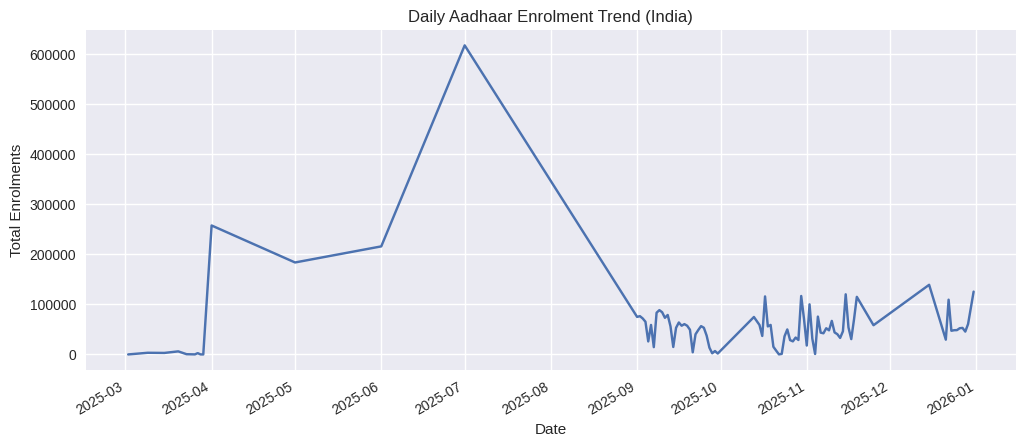

In [37]:
daily_trend = enrolment_df.groupby('date')['total_enrolment'].sum()

plt.figure(figsize=(12,5))
daily_trend.plot()
plt.title("Daily Aadhaar Enrolment Trend (India)")
plt.xlabel("Date")
plt.ylabel("Total Enrolments")
plt.show()


### Insights

- Aadhaar enrolment activity exhibits **significant temporal variability**, rather than a stable or uniform daily pattern.
- A pronounced surge is observed during the mid-period of the timeline, followed by a sharp decline, indicating **time-bound enrolment drives or operational scaling events** rather than continuous enrolment demand.
- The latter part of the timeline shows **lower but fluctuating enrolment levels**, suggesting a transition from high-intensity enrolment phases to more routine, baseline activity.
- Short-term spikes and dips in the later period indicate **operational volatility**, which may be influenced by localized enrolment initiatives, capacity constraints, or reporting cycles.

**Implications:**  
These patterns suggest that Aadhaar enrolment demand is largely **event-driven and seasonal**, rather than evenly distributed over time. Understanding such temporal fluctuations can support **dynamic staffing, infrastructure planning, and scheduling of enrolment drives**, ensuring resources are aligned with periods of peak demand while minimizing underutilization during low-activity phases.


## 5.Enrolment Stability and Volatility Analysis

This section examines how stable Aadhaar enrolment activity is over time.  
Instead of focusing only on volume, rolling variability is analyzed to identify periods of operational stability and high fluctuation.

High volatility may indicate temporary enrolment drives, infrastructure stress, or reporting inconsistencies.


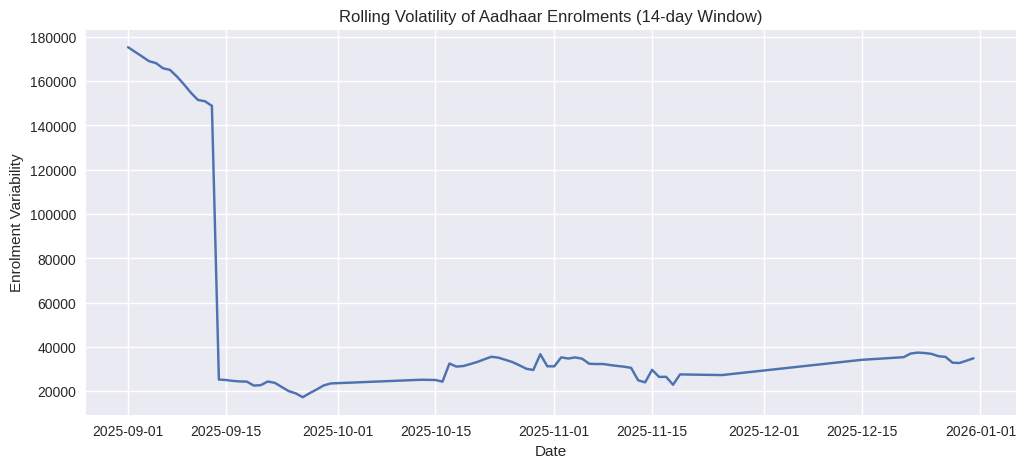

In [42]:
rolling_volatility = daily_trend.rolling(14).std()

plt.figure(figsize=(12,5))
plt.plot(rolling_volatility)
plt.title("Rolling Volatility of Aadhaar Enrolments (14-day Window)")
plt.xlabel("Date")
plt.ylabel("Enrolment Variability")
plt.show()


### Insights

- The enrolment volatility is **very high during the initial phase**, indicating sharp day-to-day fluctuations in enrolment activity.
- A sudden and sustained drop in volatility is observed after the early period, suggesting a transition from **intensive or irregular enrolment activity to a more stable operational phase**.
- In the later timeline, volatility remains comparatively low but shows **gradual increases**, reflecting moderate fluctuations around a steady baseline rather than extreme swings.
- Short spikes in volatility during the later period indicate **localized or short-term enrolment variations**, rather than systemic instability.

**Implications:**  
Periods of high volatility may require **flexible staffing, surge capacity, and closer operational monitoring**, while low-volatility phases indicate predictable demand suitable for routine operations. Tracking enrolment variability alongside enrolment volume enables UIDAI to **differentiate between structural demand shifts and temporary operational fluctuations**, improving capacity planning and service reliability.


## 6.Spatial Distribution Analysis

Spatial analysis is conducted to understand enrolment distribution across states and districts.

This helps identify:
- Regions contributing disproportionately to enrolments  
- Persistently underperforming districts  
- Intra-state enrolment disparities


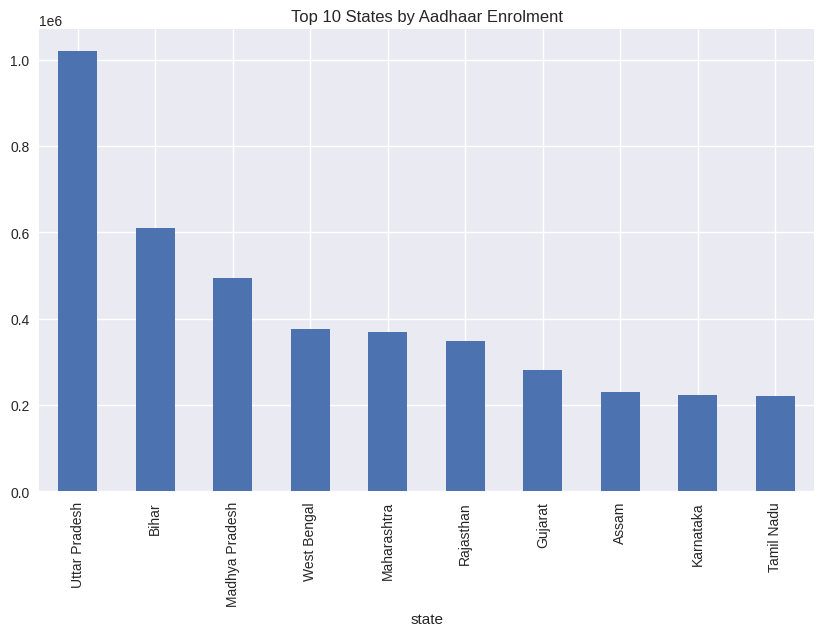

In [38]:
state_enrolment = enrolment_df.groupby('state')['total_enrolment'].sum().sort_values(ascending=False)

plt.figure(figsize=(10,6))
state_enrolment.head(10).plot(kind='bar')
plt.title("Top 10 States by Aadhaar Enrolment")
plt.show()


### Insights

- Aadhaar enrolment activity is **highly concentrated among a limited number of states**, with the top-performing states contributing a disproportionately large share of total enrolments.
- The leading state shows a significantly higher enrolment volume compared to others, indicating **strong regional dominance rather than uniform national distribution**.
- The gradual decline in enrolment volumes across the remaining top states highlights **substantial inter-state variation** in enrolment activity.
- States outside the top tier likely contribute marginally to overall enrolments, suggesting potential differences in population coverage, enrolment demand, or operational reach.

**Implications:**  
State-level aggregation can obscure **intra-state and district-level disparities**, and high enrolment volumes in a few states may mask underperformance elsewhere. These findings support the need for **region-specific enrolment strategies**, where resource allocation and outreach efforts are tailored based on state-level demand and capacity rather than relying on national averages.


## 7.District Performance Segmentation

Districts are grouped based on their total enrolment volumes to identify natural performance tiers such as high, medium, and low enrolment regions.

This segmentation supports differentiated operational strategies instead of one-size-fits-all interventions.
**bold text**

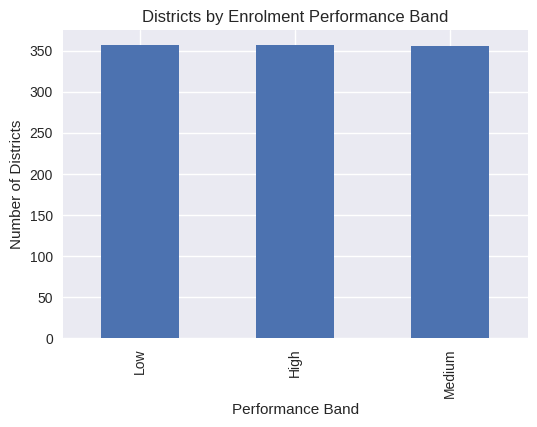

In [43]:
district_perf = district_totals.reset_index()
district_perf['performance_band'] = pd.qcut(
    district_perf['total_enrolment'],
    q=3,
    labels=['Low', 'Medium', 'High']
)

band_counts = district_perf['performance_band'].value_counts()

plt.figure(figsize=(6,4))
band_counts.plot(kind='bar')
plt.title("Districts by Enrolment Performance Band")
plt.xlabel("Performance Band")
plt.ylabel("Number of Districts")
plt.show()


### Insights

- Districts are **almost evenly distributed across low, medium, and high enrolment performance bands**, indicating substantial heterogeneity in enrolment activity at the district level.
- The absence of a dominant performance band suggests that **enrolment outcomes are not uniformly skewed**, but instead reflect diverse operational and contextual conditions across districts.
- The presence of a large number of low-performing districts alongside high-performing ones highlights **uneven service reach and utilisation**, even within the same broader administrative framework.

**Implications:**  
This segmentation enables **tier-based operational planning**, where low-performing districts can be prioritized for outreach and capacity-building efforts, medium-performing districts can be stabilised through incremental improvements, and high-performing districts can be optimised for efficiency. Such differentiated strategies are more effective than uniform interventions applied across all districts.


## 8.Enrolment Concentration Analysis

This analysis evaluates how Aadhaar enrolments are distributed across districts.  
Rather than assuming uniform participation, a cumulative contribution analysis is used to determine whether enrolment activity is concentrated in a small subset of districts.

Understanding enrolment concentration helps assess whether service delivery is equitably distributed or operationally centralized.


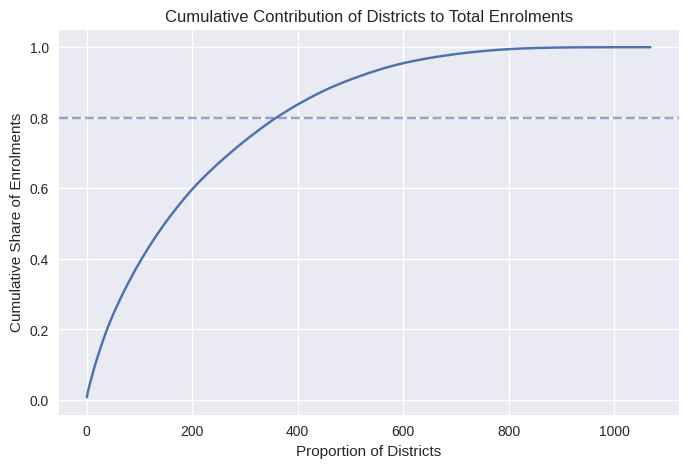

In [41]:
# District-wise total enrolments
district_totals = (
    enrolment_df
    .groupby(['state', 'district'])['total_enrolment']
    .sum()
    .sort_values(ascending=False)
)

cumulative_share = district_totals.cumsum() / district_totals.sum()

plt.figure(figsize=(8,5))
plt.plot(cumulative_share.values)
plt.axhline(0.8, linestyle='--', alpha=0.6)
plt.title("Cumulative Contribution of Districts to Total Enrolments")
plt.xlabel("Proportion of Districts")
plt.ylabel("Cumulative Share of Enrolments")
plt.show()


### Insights

- Aadhaar enrolment activity is **highly concentrated across a relatively small proportion of districts**, as evidenced by the steep initial rise of the cumulative contribution curve.
- Approximately a **minority of districts account for a majority of total enrolments**, while the remaining districts contribute progressively smaller shares.
- The curve gradually flattens after the initial segment, indicating a **long tail of districts with low individual enrolment contribution**.

**Implications:**  
This concentration pattern suggests that enrolment infrastructure and demand are **not evenly distributed geographically**. Operational strategies based solely on aggregate or state-level metrics may overlook underperforming regions. District-level targeting—such as deploying mobile enrolment units, localized awareness programs, or capacity enhancements—can help address enrolment imbalances and improve overall coverage equity.


## 9.Age-Group Enrolment Analysis

Age-wise enrolment analysis evaluates demographic coverage across regions.  
The proportion of child enrolments is examined to identify areas with delayed or low early Aadhaar registration.


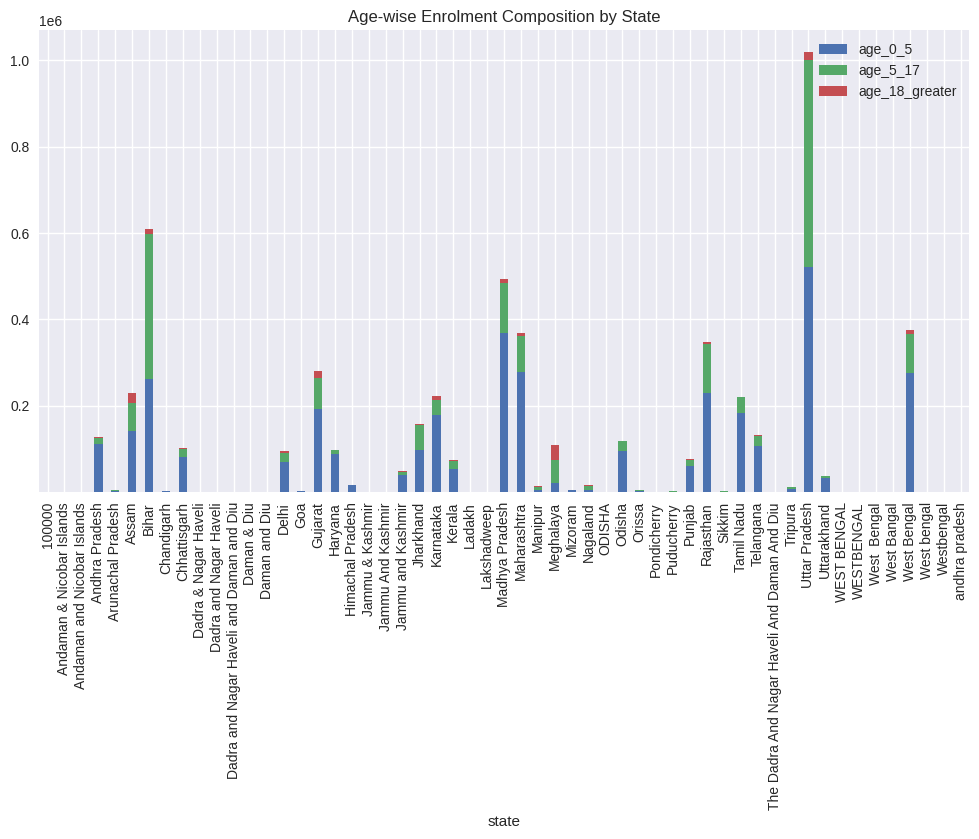

In [39]:
enrolment_df['child_ratio'] = (
    enrolment_df['age_0_5'] + enrolment_df['age_5_17']
) / enrolment_df['total_enrolment']

age_state = enrolment_df.groupby('state')[count_cols].sum()
age_state.plot(kind='bar', stacked=True, figsize=(12,6))
plt.title("Age-wise Enrolment Composition by State")
plt.show()


### Insights

- Aadhaar enrolment composition varies **significantly across states**, with noticeable differences in the proportion of child and adult enrolments.
- Several states exhibit a **high concentration of adult enrolments**, while child enrolments (ages 0–5 and 5–17) contribute a comparatively smaller share, indicating **delayed or lower early-age registration**.
- In contrast, some states display a **more balanced age-wise enrolment mix**, suggesting stronger early enrolment coverage and more continuous demographic inclusion.
- The wide variation in age-group composition highlights that **overall enrolment volume alone does not reflect demographic coverage quality**.

**Implications:**  
States with relatively low child enrolment proportions may benefit from **targeted early-age enrolment initiatives**, such as school-linked Aadhaar drives or child-focused awareness programs. Monitoring age-wise composition alongside total enrolment volumes enables more **demographically inclusive planning**, ensuring that Aadhaar coverage extends uniformly across age groups rather than being concentrated primarily among adults.


## 10.Relationship Between Child and Adult Enrolment

This analysis explores the relationship between child and adult enrolment volumes across districts.

A weak relationship may indicate delayed child enrolment despite active adult registration, highlighting demographic coverage gaps.


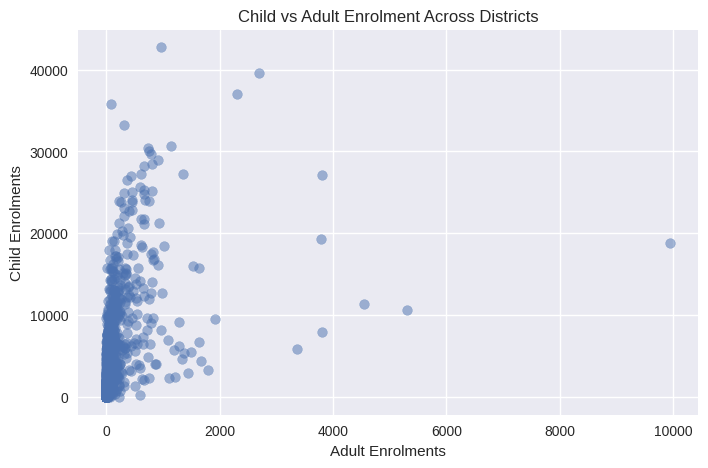

In [44]:
district_age = enrolment_df.groupby(
    ['state', 'district']
)[['age_0_5', 'age_5_17', 'age_18_greater']].sum()

district_age['child_enrolment'] = (
    district_age['age_0_5'] + district_age['age_5_17']
)

plt.figure(figsize=(8,5))
plt.scatter(
    district_age['age_18_greater'],
    district_age['child_enrolment'],
    alpha=0.5
)
plt.xlabel("Adult Enrolments")
plt.ylabel("Child Enrolments")
plt.title("Child vs Adult Enrolment Across Districts")
plt.show()


### Insights

- The relationship between adult and child enrolments across districts is **weak and highly dispersed**, indicating that higher adult enrolment does not consistently translate into proportionally higher child enrolment.
- A large cluster of districts shows **low adult enrolments with moderate to high child enrolments**, while some districts with relatively high adult enrolments exhibit **comparatively low child enrolment levels**.
- The presence of several outlier districts highlights **asymmetric enrolment behavior**, where one demographic group is being enrolled more actively than the other.

**Implications:**  
These patterns suggest that adult-driven enrolment activity alone is insufficient to ensure comprehensive child coverage. Districts exhibiting high adult but low child enrolment may benefit from **child-specific enrolment interventions**, such as school-linked Aadhaar registration programs or targeted awareness campaigns for parents and guardians. Monitoring the balance between adult and child enrolment enables more **demographically balanced and inclusive service delivery**.


## 11.Anomaly Detection

Statistical anomaly detection is applied to identify irregular enrolment behavior.  
A rolling-window approach highlights days with unusually high or low enrolment activity relative to historical patterns.


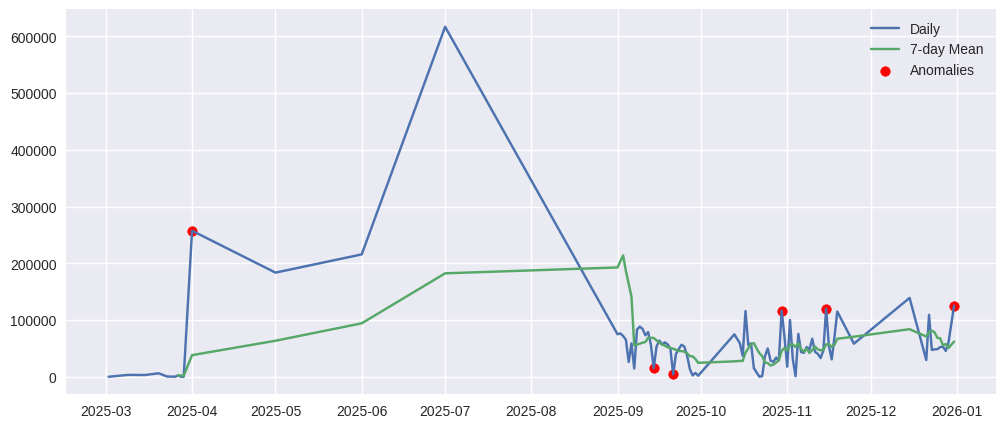

In [40]:
rolling_mean = daily_trend.rolling(7).mean()
rolling_std = daily_trend.rolling(7).std()

anomalies = daily_trend[
    (daily_trend > rolling_mean + 2*rolling_std) |
    (daily_trend < rolling_mean - 2*rolling_std)
]

plt.figure(figsize=(12,5))
plt.plot(daily_trend, label="Daily")
plt.plot(rolling_mean, label="7-day Mean")
plt.scatter(anomalies.index, anomalies.values, color='red', label="Anomalies")
plt.legend()
plt.show()


### Insights

- The anomaly detection highlights **specific dates where enrolment activity deviates sharply from the expected short-term trend**, as defined by the rolling average and variability.
- Early anomalies correspond to **sudden enrolment surges**, while later anomalies include both unusually low and unusually high enrolment days relative to the surrounding period.
- The clustering of anomalies in certain time windows suggests that **enrolment irregularities are not random**, but occur during identifiable operational phases.

**Implications:**  
Detecting such anomalies enables proactive **operational monitoring and diagnostic analysis**. Sudden enrolment spikes may indicate short-term enrolment drives or reporting consolidation, while unexpected drops could signal service disruptions or access constraints. Incorporating anomaly detection into routine monitoring can help UIDAI **identify and respond to irregular enrolment behavior in near real time**, improving service reliability and data integrity.


## 12.Identification of Persistently Low Enrolment Districts

This analysis identifies districts that consistently record low enrolment activity over time.

Persistent underperformance suggests structural barriers such as limited access, awareness gaps, or logistical constraints.


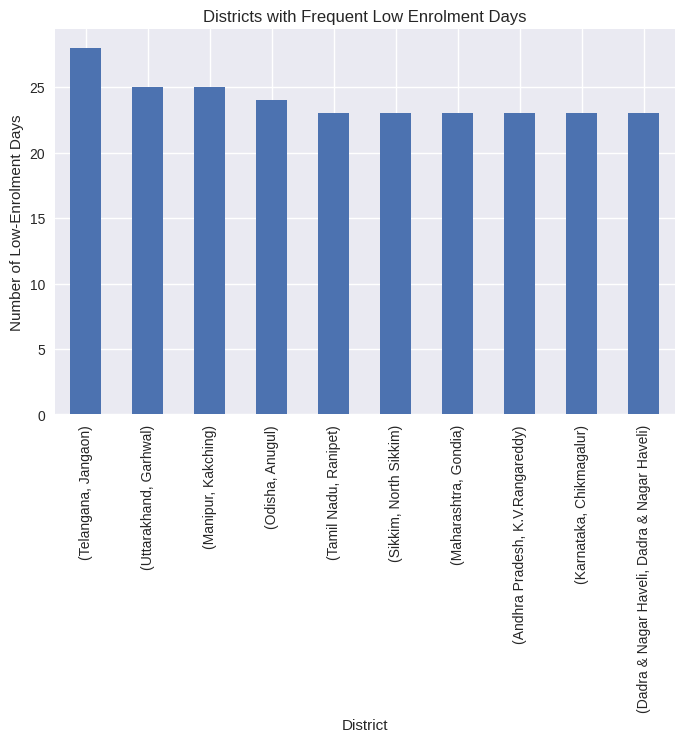

In [45]:
district_daily = enrolment_df.groupby(
    ['state', 'district', 'date']
)['total_enrolment'].sum()

low_threshold = district_daily.quantile(0.1)

low_days = (district_daily < low_threshold).groupby(
    ['state', 'district']
).sum()

low_days = low_days.sort_values(ascending=False).head(10)

plt.figure(figsize=(8,5))
low_days.plot(kind='bar')
plt.title("Districts with Frequent Low Enrolment Days")
plt.xlabel("District")
plt.ylabel("Number of Low-Enrolment Days")
plt.show()


### Insights

- A small group of districts consistently records a **high number of low-enrolment days**, indicating persistent underperformance rather than isolated or random dips.
- The recurrence of low enrolment across many days suggests **structural or systemic factors** affecting service utilization in these districts.
- The presence of districts from different states in this group indicates that **low enrolment is not confined to a single region**, but occurs across diverse geographic and administrative contexts.

**Implications:**  
Districts with frequent low-enrolment days may require **long-term, targeted interventions** rather than short-term corrective measures. Potential actions include strengthening enrolment infrastructure, deploying mobile enrolment units, improving local awareness, or adjusting operational hours. Identifying persistently low-performing districts enables UIDAI to **prioritize resources where enrolment access and uptake are consistently constrained**, improving overall coverage equity.


## 13.Key Findings

- Aadhaar enrolment activity is temporally uneven and largely event-driven, with clear phases of high and low operational intensity.
- Enrolment demand is geographically concentrated, with a small subset of districts contributing a majority of total enrolments.
- Significant inter-district and intra-state disparities persist, indicating that state-level aggregation masks local performance gaps.
- Child enrolment coverage varies widely across regions and does not consistently scale with adult enrolment activity.
- Recurrent anomalies and persistently low-enrolment districts suggest structural access or utilisation challenges rather than temporary disruptions.


## 14.Operational and Policy Recommendations

- Implement dynamic staffing and capacity allocation during high-demand enrolment periods identified through temporal trend analysis.
- Prioritise district-level interventions in persistently low-performing regions using mobile enrolment units and localized outreach programs.
- Introduce child-focused enrolment initiatives, such as school-linked Aadhaar drives, in districts exhibiting low child-to-adult enrolment ratios.
- Integrate anomaly detection into routine monitoring dashboards to flag unusual enrolment behavior for timely operational review.
- Shift from uniform state-level planning to district-tiered strategies based on enrolment performance segmentation.


## 15.Conclusion

This study demonstrates how systematic analysis of Aadhaar enrolment data can uncover meaningful temporal, spatial, and demographic patterns.

The insights generated provide a data-driven foundation for targeted policy interventions and operational optimization, supporting UIDAI’s objective of improving Aadhaar coverage and service delivery efficiency.


## 16.Limitations and Future Scope

- The analysis is based on historical enrolment records and does not incorporate population baselines, which could further contextualize enrolment coverage.
- Causal factors behind enrolment variations cannot be inferred solely from enrolment data and may require supplementary administrative or socio-economic datasets.
- Future work could extend this framework by integrating demographic update and biometric datasets to provide a more holistic view of Aadhaar service utilization.


In [46]:
summary_metrics = {
    "Total Enrolments": enrolment_df['total_enrolment'].sum(),
    "Total Districts": enrolment_df[['state','district']].drop_duplicates().shape[0],
    "Average Daily Enrolments": daily_trend.mean(),
    "Peak Daily Enrolments": daily_trend.max()
}

pd.DataFrame(summary_metrics, index=["Value"])


,Total Enrolments,Total Districts,Average Daily Enrolments,Peak Daily Enrolments
Value,5435702,1070,59083.717391,616868
